# General Benchmarking Debugging Tool

This notebook demonstrates the debugging mode used to differentiate the performance on different output results for text and image explanations. In the case of multiple output tokens / classes, it is usually useful to see the performance individually for any outliers. 

This notebook contains debugging examples for both text and images. 

### Text Example (Summarization)

Please reference "Abstractive Summarization Benchmark Demo.ipynb" for more description about this benchmarking example.

In [1]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import nlp
import shap
import shap.benchmark as benchmark
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model =  AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-xsum-12-6")

In [3]:
dataset = nlp.load_dataset('xsum',split='train')

Using custom data configuration default


In [4]:
s = dataset['document'][0:1]

In [5]:
explainer = shap.Explainer(model,tokenizer)

explainers.Partition is still in an alpha state, so use with caution...


In [6]:
shap_values = explainer(s)

Partition explainer: 2it [00:19,  9.59s/it]                                       


In [7]:
sort_order = 'positive'
perturbation = 'keep'

In [8]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(explainer.model, explainer.masker, sort_order, perturbation)
mask_vals, curves, aucs = sequential_perturbation.model_score(shap_values, s, debug_mode=True)

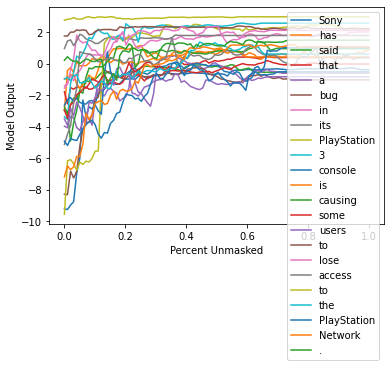

In [9]:
xs = np.linspace(0,1,100)
for index in range(len(curves)):
    plt.plot(xs, curves[index,:], label='{}'.format(shap_values.output_names[0][index]))
    plt.ylabel('Model Output')
    plt.xlabel('Percent Unmasked')
    plt.legend()
plt.show() 

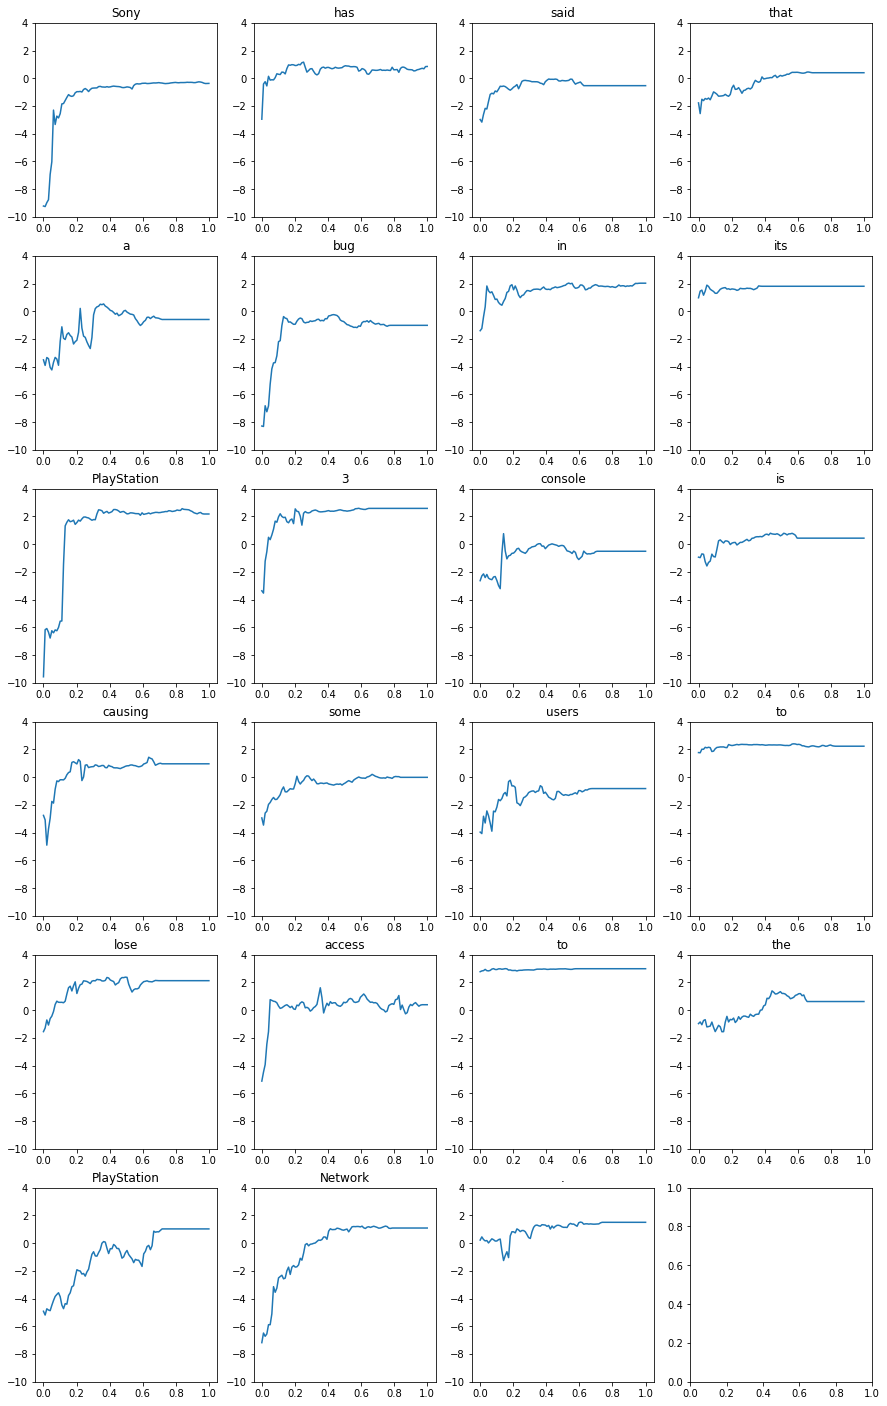

In [10]:
fig, axs = plt.subplots(6,4,figsize=(15,25)) 
xs = np.linspace(0,1,100)
for index in range(len(curves)):
    x = index // 4
    y = index % 4 
    axs[x,y].plot(xs, curves[index,:])
    axs[x,y].set_title('{}'.format(shap_values.output_names[0][index]))
    axs[x,y].set_ylim(-10,4)
plt.show() 

### Image Example (Multi-class)

Please reference "Image Multiclass Classification Benchmark Demo.ipynb" for more description about this benchmarking example.

In [11]:
import json
import numpy as np
import shap
import shap.benchmark as benchmark
import tensorflow as tf
import scipy as sp
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt 
%matplotlib inline

In [12]:
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

In [13]:
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

In [14]:
def f(x):
    tmp = x.copy()
    if len(tmp.shape) == 2: 
        tmp = tmp.reshape(tmp.shape[0], *X[0].shape)
    preprocess_input(tmp)
    return model(tmp)

In [15]:
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

In [16]:
explainer = shap.Explainer(f, masker, output_names=class_names)

explainers.Partition is still in an alpha state, so use with caution...


In [17]:
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]) 

Partition explainer:  50%|█████████████████                 | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [01:01, 20.59s/it]                                       


In [18]:
output = f(X[1:3]).numpy()
num_of_outputs = 4
sorted_indexes = np.argsort(-output,axis=1)
sliced_indexes = np.array([index_list[:num_of_outputs] for index_list in sorted_indexes])

In [19]:
# getting output labels 
labels = np.array(class_names)
sliced_labels = np.array([labels[index_list[:num_of_outputs]] for index_list in sorted_indexes])

In [20]:
sort_order = 'positive'
perturbation = 'keep'

In [21]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(explainer.model, explainer.masker, sort_order, perturbation)
mask_vals, curves, aucs = sequential_perturbation.model_score(shap_values, X[1:2], indices=sliced_indexes[0], debug_mode=True)

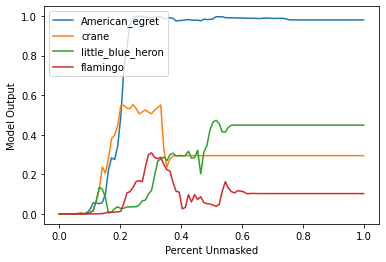

In [22]:
xs = np.linspace(0,1,100)
for index in range(len(curves)):
    plt.plot(xs, curves[index,:], label='{}'.format(sliced_labels[0][index]))
    plt.ylabel('Model Output')
    plt.xlabel('Percent Unmasked')
    plt.legend()
plt.show() 

In [23]:
image = X[1:2][0] / 255 
top_class = np.array(mask_vals)[0][0:int(np.array(mask_vals)[0].shape[0]/num_of_outputs), :]
top_class = top_class.reshape(top_class.shape[0], *X[0].shape)

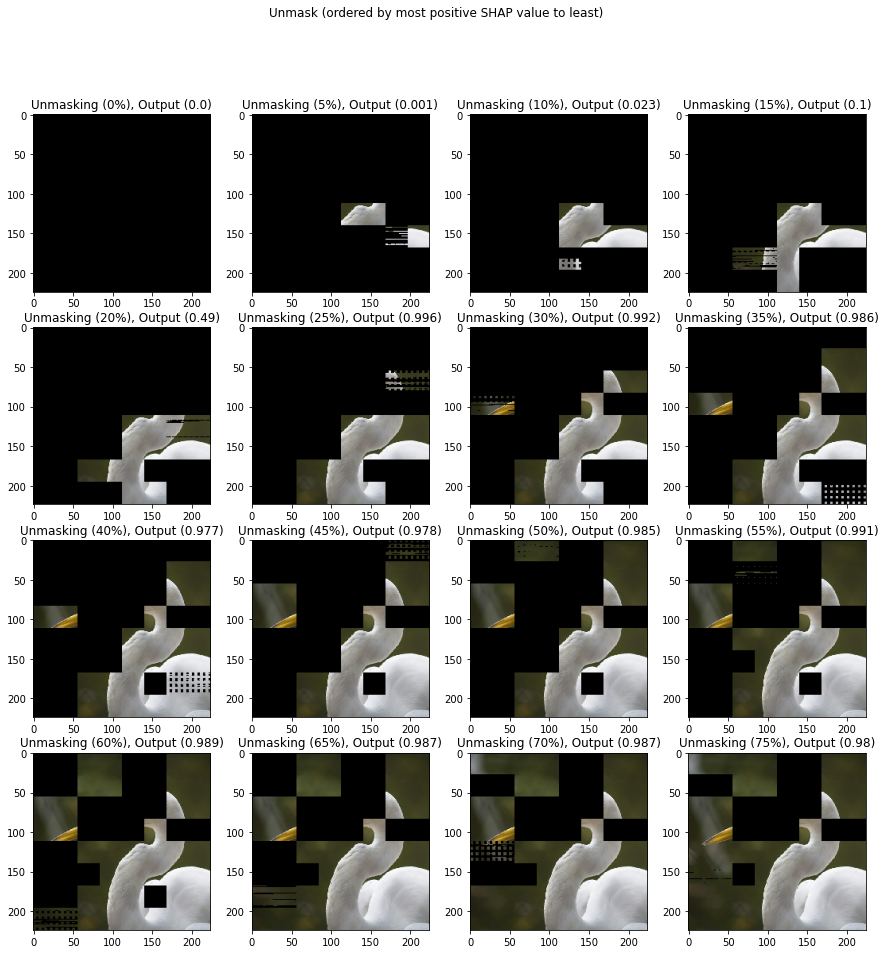

In [24]:
masked_image = image * top_class[0].astype(int)
fig, axs = plt.subplots(4,4,figsize=(15,15))
for percent in range(0, 80, 5):
    masked_image = image * top_class[percent].astype(int)
    x = percent // 5 // 4
    y = percent // 5 % 4
    axs[x, y].imshow(masked_image)
    axs[x, y].set_title('Unmasking ({}%), Output ({})'.format(percent, round(curves[0][percent],3)))
fig.suptitle('Unmask (ordered by most positive SHAP value to least)')
plt.show()